# Offside detection project

## This program detects offside in a image
## The program has four main parts:
## 1-Player detection : using a pretrained model that detects players, referees and goalkeepers and assigns them different classes
## 2-Team classification : classify players into two teams, using SIGLIP and UMAP models with K means clustring
## 3-Pitch key point detection and perspective correction : detecting key points on the pitch using a refined model and perspective correction using OpenCV's perspctive transform
## 4-Offside decision : using corrected player positions to determine wether they are offside or not

# Part 1 : player detection

In [1]:
from inference import get_model
import supervision as sv
import cv2

[05/11/25 14:38:26] WARNING  Your inference package version 0.48.1 is out of date! Please upgrade to ]8;id=890597;file://C:\Users\PC\miniconda3\envs\offside-2\Lib\site-packages\inference\core\__init__.py\__init__.py]8;;\:]8;id=881646;file://C:\Users\PC\miniconda3\envs\offside-2\Lib\site-packages\inference\core\__init__.py#41\41]8;;\
                             version 0.49.1 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

C:\Users\PC\miniconda3\envs\offside-2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\PC\miniconda3\envs\offside-2\Lib\site-packages\inference\models\utils.py:340: ModelDependencyMissing: Your `inference` configuration does not support Qwen2.5-VL model. Use pip install 'inference[transformers]' to install missing requirements.
  warnings.warn(
C:\Users\PC\miniconda3\envs\offside-2\Lib\site-packages\inference\models\utils.py:352: ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.
  warnings.warn(
C:\Users\PC\miniconda3\envs\offside-2\Lib\site-packages\inference\models\utils.py:362: ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install mis

In [2]:
model = get_model(
    model_id="football-players-detection-3zvbc/12"
)

In [3]:
image = cv2.imread("test5.png")

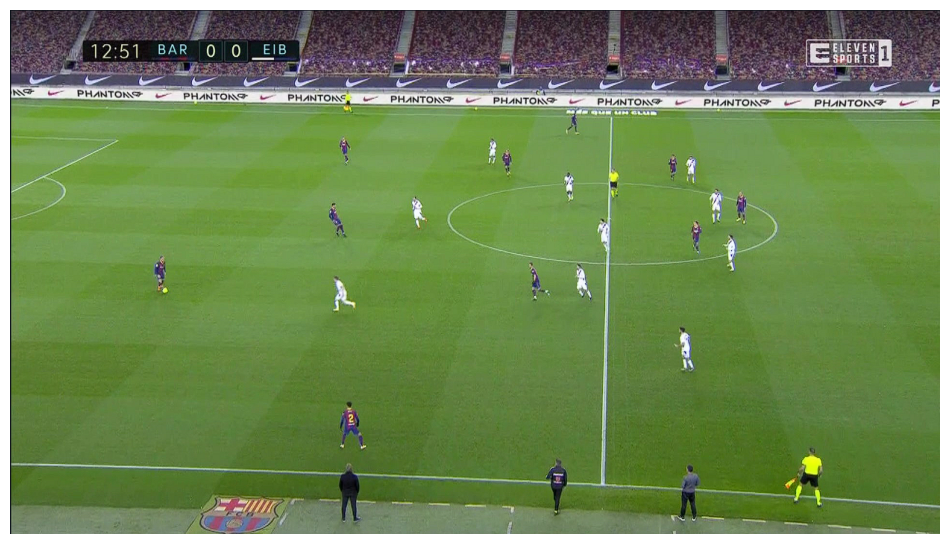

In [4]:
sv.plot_image(image)

In [5]:
results = model.infer(image)[0]

In [6]:
detections = sv.Detections.from_inference(results)

In [24]:
detections

Detections(xyxy=array([[ 695.,  339.,  724.,  391.],
       [ 442.,  525.,  479.,  591.],
       [ 432.,  357.,  464.,  407.],
       [ 742.,  218.,  757.,  259.],
       [ 442.,  171.,  457.,  209.],
       [ 906.,  196.,  920.,  235.],
       [ 538.,  250.,  559.,  295.],
       [ 427.,  259.,  452.,  306.],
       [ 745.,  138.,  764.,  169.],
       [ 913.,  283.,  928.,  328.],
       [ 757.,  340.,  781.,  393.],
       [ 973.,  244.,  988.,  288.],
       [ 893.,  425.,  918.,  486.],
       [ 193.,  330.,  211.,  380.],
       [ 660.,  187.,  674.,  226.],
       [ 938.,  240.,  955.,  288.],
       [ 641.,  172.,  653.,  210.],
       [ 955.,  301.,  974.,  352.],
       [ 882.,  194.,  895.,  231.],
       [ 787.,  280.,  804.,  326.],
       [ 803.,  213.,  817.,  252.],
       [1038.,  586., 1090.,  666.],
       [ 447.,  109.,  460.,  142.],
       [ 203.,  372.,  213.,  383.]]), mask=None, confidence=array([0.91427636, 0.91253871, 0.9068867 , 0.90293545, 0.90170395,
     

In [25]:
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

In [26]:
image_copy=image.copy()

annotated_image = bounding_box_annotator.annotate(
    scene=image_copy, detections=detections)
annotated_image = label_annotator.annotate(
    scene=image_copy, detections=detections)

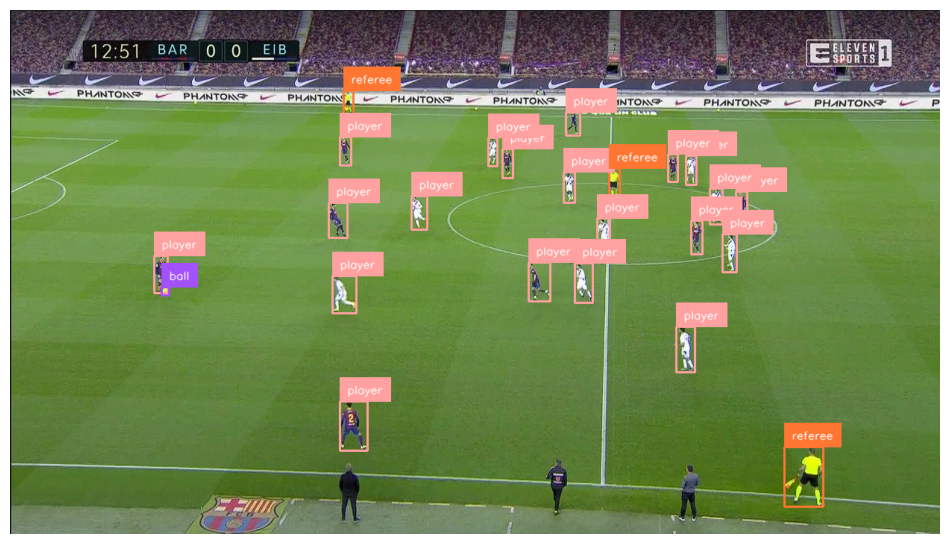

In [27]:
sv.plot_image(annotated_image)

#### now we crop every player

In [28]:
PLAYER_ID = 2
crops = []

detections_nms = detections.with_nms(threshold=0.5, class_agnostic=True)
player_detections = detections_nms[detections_nms.class_id == PLAYER_ID]
players_crops = [sv.crop_image(image, xyxy) for xyxy in player_detections.xyxy]
crops += players_crops

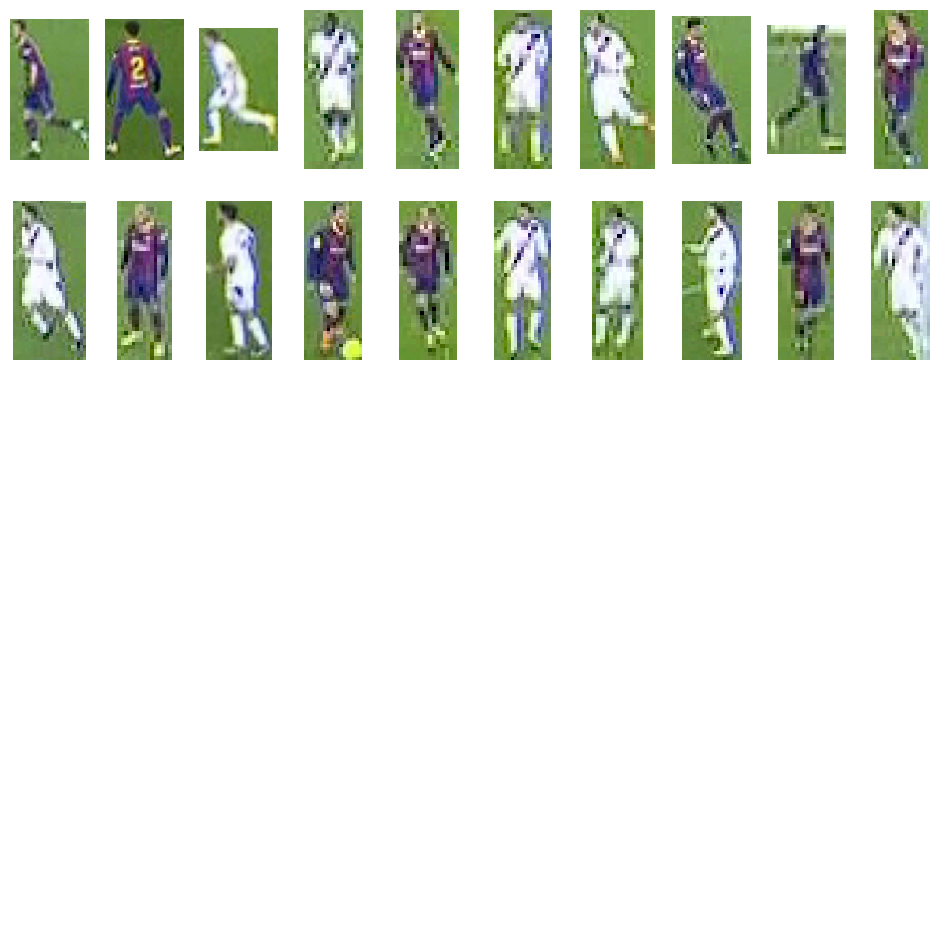

In [29]:
sv.plot_images_grid(crops[:100], grid_size=(5, 10))

# Part 2 : team classification

## now that detecting players, goalkeepers and referees is done, it's time to separate players into teams

## we will use a siglip, umap model with Kmeans clustring

In [30]:
import torch 
from transformers import AutoProcessor, SiglipVisionModel 

In [31]:
SIGLIP_MODEL_PATH = '"google/siglip-base-patch16-224"' 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained("google/siglip-base-patch16-224").to(DEVICE) 
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained("google/siglip-base-patch16-224") 

In [32]:
crops = [sv.cv2_to_pillow(crop) for crop in crops]

In [33]:
from tqdm import tqdm

In [34]:
data = []
with torch.no_grad():
    for crop in tqdm(crops, desc='embedding extraction'):
        inputs = EMBEDDINGS_PROCESSOR(images=crop, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)



embedding extraction: 100%|████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.25it/s]


In [35]:
import numpy as np

data = np.concatenate(data)

In [46]:
import umap
from sklearn.cluster import KMeans

REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

In [47]:
##team classifier fit
projections = REDUCER.fit_transform(data)
clusters = CLUSTERING_MODEL.fit_predict(projections)

In [48]:
clusters

array([1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0],
      dtype=int32)

In [49]:
player_detections.class_id=clusters

In [50]:
player_detections_copy=player_detections

In [52]:
player_detections_copy.data['class_name'] = np.where(player_detections_copy.class_id == 0, "team 0", "team 1")

In [53]:
player_detections_copy

Detections(xyxy=array([[695., 339., 724., 391.],
       [442., 525., 479., 591.],
       [432., 357., 464., 407.],
       [742., 218., 757., 259.],
       [442., 171., 457., 209.],
       [906., 196., 920., 235.],
       [538., 250., 559., 295.],
       [427., 259., 452., 306.],
       [745., 138., 764., 169.],
       [913., 283., 928., 328.],
       [757., 340., 781., 393.],
       [973., 244., 988., 288.],
       [893., 425., 918., 486.],
       [193., 330., 211., 380.],
       [660., 187., 674., 226.],
       [938., 240., 955., 288.],
       [641., 172., 653., 210.],
       [955., 301., 974., 352.],
       [882., 194., 895., 231.],
       [787., 280., 804., 326.]]), mask=None, confidence=array([0.91427636, 0.91253871, 0.9068867 , 0.90293545, 0.90170395,
       0.90044677, 0.89934599, 0.89880216, 0.89859331, 0.89792681,
       0.89339221, 0.89202738, 0.88620996, 0.88557732, 0.88536298,
       0.88163078, 0.87628973, 0.86956644, 0.86786306, 0.85071373]), class_id=array([1, 1, 0, 0, 1,

In [54]:
image_copy2=image.copy()

annotated_image_2 = bounding_box_annotator.annotate(
    scene=image_copy2, detections=player_detections_copy)
annotated_image_2 = label_annotator.annotate(
    scene=annotated_image_2, detections=player_detections_copy)

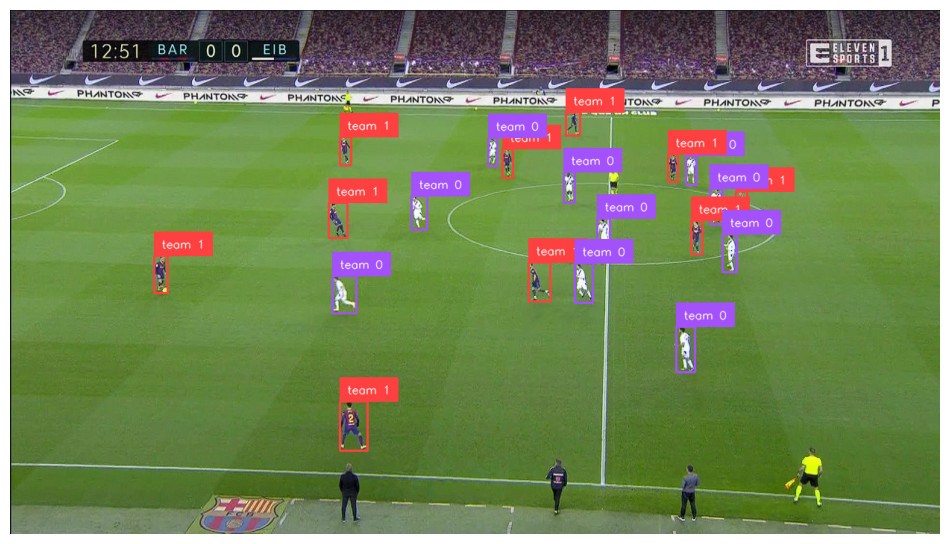

In [55]:
sv.plot_image(annotated_image_2)

## now we ask the user about which is the attacking team and which direction are they facing

In [56]:
ATTACKING_TEAM=input('which is the attacking team : 1 or 0 ?just type the number :')

which is the attacking team : 1 or 0 ?just type the number : 1


In [57]:
ATTACKING_DIRECTION=input('in which direction are they attacking : left of the image or right ? just type l for left or r for right :')

in which direction are they attacking : left of the image or right ? just type l for left or r for right : r


## now we have separated the two teams, now we will take the position of each players

### in this implementation we will use the point closest to goal of each player to determine wether that player is offside, it's not perfect but it is simple and quite accurate for most situations

In [58]:
team1_xy=[]
team0_xy=[]

for detection in player_detections:
    xyxy=detection[0]
    class_id=detection[3]
    if ATTACKING_DIRECTION == 'l':
        x_player=xyxy[0]
        y_player=xyxy[3]
    else :
        x_player=xyxy[2]
        y_player=xyxy[3]
    if class_id==0:
        team0_xy.append([x_player,y_player])
    else:
        team1_xy.append([x_player,y_player])

In [59]:
import matplotlib.pyplot as plt

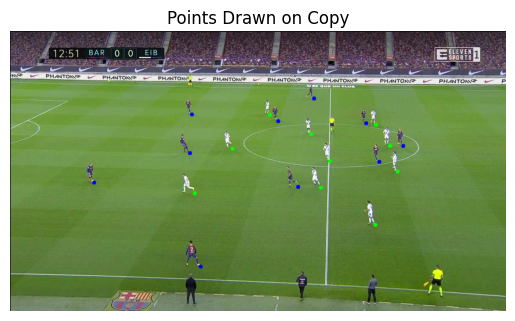

In [60]:
# let's visualize the points

image_copy3 = image.copy()

# Draw each point on the copy
for (x, y) in team0_xy:
    cv2.circle(image_copy3, (int(x), int(y)), radius=5, color=(0, 255, 0), thickness=-1)

for (x, y) in team1_xy:
    cv2.circle(image_copy3, (int(x), int(y)), radius=5, color=(255, 0, 0), thickness=-1)

# Convert BGR (OpenCV) to RGB (matplotlib)
image_rgb = cv2.cvtColor(image_copy3, cv2.COLOR_BGR2RGB)

# Display using matplotlib
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Points Drawn on Copy")
plt.show()

# Part 3 : pitch key point detection and perspective correction

##### we will use a pretrained model for key points detection on the pitch
##### this model will detect key points on the pitch, like corners, goal posts and penaly spot, which will help us in creating a homography matrix to correct the perspective distortion of the pitch caused by the camera angle

In [61]:
# retrieve api key for the model
import json

with open('secret.json') as f:
    secrets = json.load(f)

API_KEY_ROBOFLOW = secrets['api_key_roboflow']

In [62]:
PITCH_DETECTION_MODEL=get_model("football-field-detection-f07vi/15",API_KEY_ROBOFLOW)

In [63]:
vertex_annotator = sv.VertexAnnotator( 
    color=sv.Color.from_hex('#FF1493'),
    radius=8
)

In [64]:
image_copy4 = image.copy()

In [65]:
result = PITCH_DETECTION_MODEL.infer(image_copy4, confidence=0.3)[0]

In [66]:
key_points = sv.KeyPoints.from_inference(result)

In [67]:
filter=key_points.confidence[0]>0.5
frame_reference_points=key_points.xy[0][filter]
frame_reference_key_points=sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...]) 

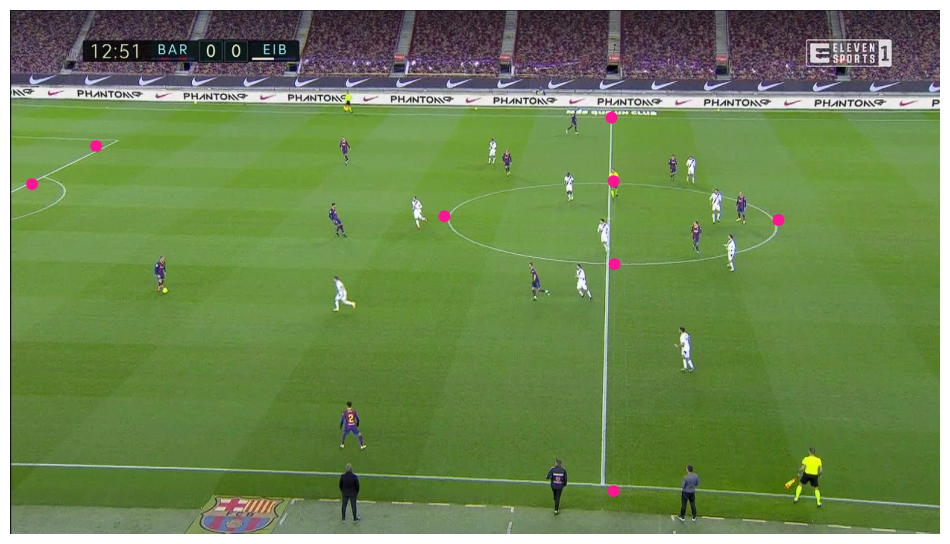

In [68]:
annotated_frame = vertex_annotator.annotate(image_copy4, frame_reference_key_points) 

sv.plot_image(annotated_frame)

## now onto homography

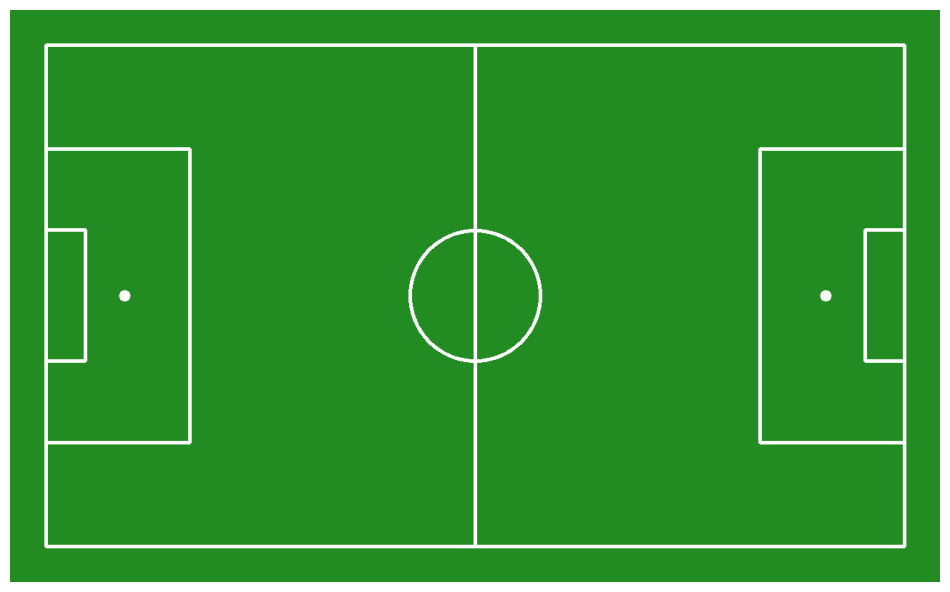

In [69]:
from sports.annotators.soccer import draw_pitch
from sports.configs.soccer import SoccerPitchConfiguration

CONFIG = SoccerPitchConfiguration()

annotated_frame = draw_pitch(CONFIG)

sv.plot_image(annotated_frame)

In [70]:
pitch_reference_points = np.array(CONFIG.vertices)[filter]

In [71]:
# creating homography matrix

source=frame_reference_points.astype(np.float32)
target=pitch_reference_points.astype(np.float32)
HOMOGRAPHY_MATRIX, _ = cv2.findHomography(source, target, method=cv2.RANSAC)

##  now lets project the player positions on a rectangular pitch

In [72]:
team0_xy_np = np.array(team0_xy, dtype=np.float32).reshape(-1, 1, 2)
team1_xy_np = np.array(team1_xy, dtype=np.float32).reshape(-1, 1, 2)

In [73]:
team0_projected=cv2.perspectiveTransform(team0_xy_np, HOMOGRAPHY_MATRIX)
team1_projected=cv2.perspectiveTransform(team1_xy_np, HOMOGRAPHY_MATRIX)

In [74]:
pts_team0_projected = team0_projected
pts_team1_projected = team1_projected

In [75]:
pts_team0_projected = pts_team0_projected.reshape(-1, 2)    
pts_team1_projected = pts_team1_projected.reshape(-1, 2)    

In [76]:
from sports.annotators.soccer import draw_points_on_pitch

annotated_frame = draw_pitch(CONFIG)

annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pts_team0_projected,
    face_color=sv.Color.from_hex('BFFF00'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)

annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pts_team1_projected,
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)

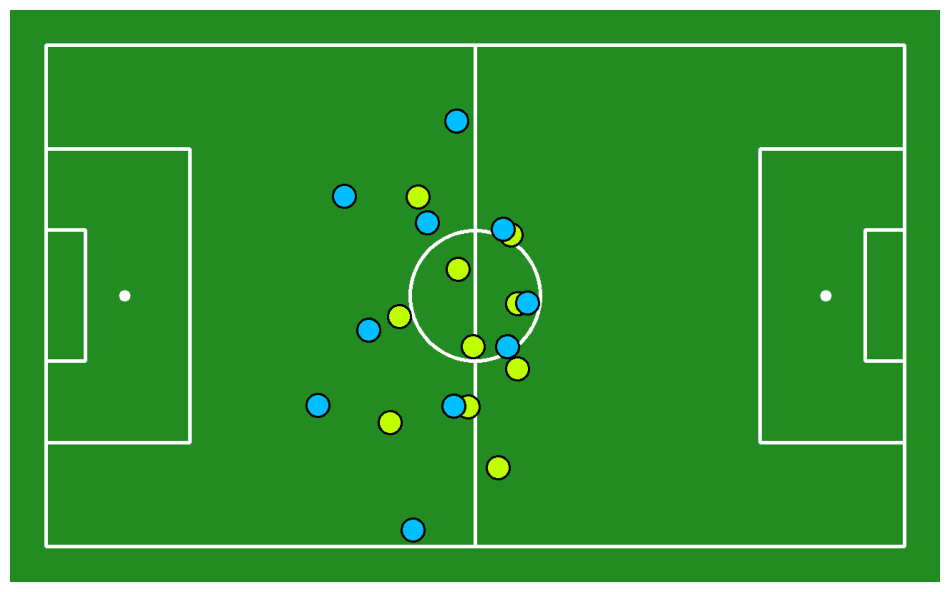

In [77]:
sv.plot_image(annotated_frame)

# Part 4 : Offside decision

### now that we projected the player positions on the pitch, we must determine which players are offside

In [78]:
# determining the position of the last defender
last_defender=None

for detection in player_detections:
    class_id=detection[3]
    if class_id != int(ATTACKING_TEAM):
        xyxy=detection[0]
        if ATTACKING_DIRECTION == 'l':
            x_player=xyxy[0]
            y_player=xyxy[3]
        else :
            x_player=xyxy[2]
            y_player=xyxy[3]
        point = np.array([[[x_player, y_player]]], dtype=np.float32)
        transformed_point = cv2.perspectiveTransform(point, HOMOGRAPHY_MATRIX)
        if last_defender is None:
            last_defender=transformed_point
            continue
        if ATTACKING_DIRECTION == 'l':
            if(transformed_point[0][0][0]<last_defender[0][0][0]) :
                last_defender=transformed_point
        else:
            if(transformed_point[0][0][0]>last_defender[0][0][0]) :
                last_defender=transformed_point

last_defender

array([[[6599.863 , 4523.3296]]], dtype=float32)

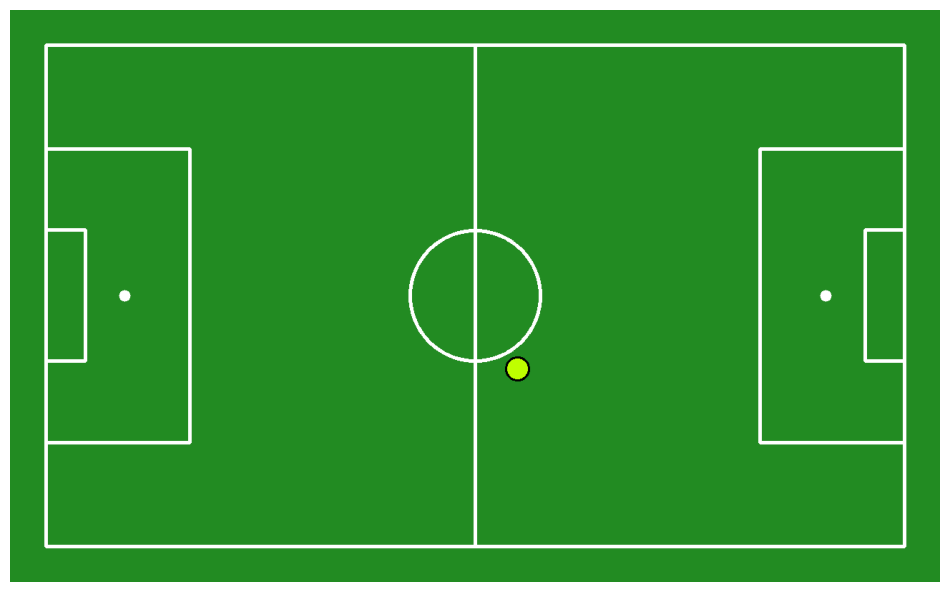

In [79]:
# drawing the position of the last defender
annotated_frame = draw_pitch(CONFIG)

annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=last_defender[0],
    face_color=sv.Color.from_hex('BFFF00'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

In [80]:
attacking_player_detections=player_detections[player_detections.class_id==int(ATTACKING_TEAM)]
attacking_player_detections.data['class_name'] = attacking_player_detections.data['class_name'].astype('<U7')

In [81]:
# comparing the positions of each attacker and determining wether they are offside or onside

for i,detection in enumerate(attacking_player_detections):
    xyxy=detection[0]
    if ATTACKING_DIRECTION == 'l':
        x_player=xyxy[0]
        y_player=xyxy[3]
    else :
        x_player=xyxy[2]
        y_player=xyxy[3]
    point = np.array([[[x_player, y_player]]], dtype=np.float32)
    transformed_point = cv2.perspectiveTransform(point, HOMOGRAPHY_MATRIX)
    if ATTACKING_DIRECTION == 'l':
        if transformed_point[0][0][0] < last_defender[0][0][0]:
            attacking_player_detections.data['class_name'][i] = 'offside'
        else:
            attacking_player_detections.data['class_name'][i] = 'onside'
    else:
        if transformed_point[0][0][0] > last_defender[0][0][0]:
            attacking_player_detections.data['class_name'][i] = 'offside'
        else:
            attacking_player_detections.data['class_name'][i] = 'onside'

In [82]:
attacking_player_detections

Detections(xyxy=array([[695., 339., 724., 391.],
       [442., 525., 479., 591.],
       [442., 171., 457., 209.],
       [427., 259., 452., 306.],
       [745., 138., 764., 169.],
       [913., 283., 928., 328.],
       [973., 244., 988., 288.],
       [193., 330., 211., 380.],
       [660., 187., 674., 226.],
       [882., 194., 895., 231.]]), mask=None, confidence=array([0.91427636, 0.91253871, 0.90170395, 0.89880216, 0.89859331,
       0.89792681, 0.89202738, 0.88557732, 0.88536298, 0.86786306]), class_id=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), tracker_id=None, data={'class_name': array(['onside', 'onside', 'onside', 'onside', 'onside', 'onside',
       'offside', 'onside', 'onside', 'onside'], dtype='<U7')}, metadata={})

In [83]:
# visualizing the results

image_copy5=image.copy()

annotated_image_5 = bounding_box_annotator.annotate(
    scene=image_copy5, detections=attacking_player_detections)
annotated_image_5 = label_annotator.annotate(
    scene=annotated_image_5, detections=attacking_player_detections)

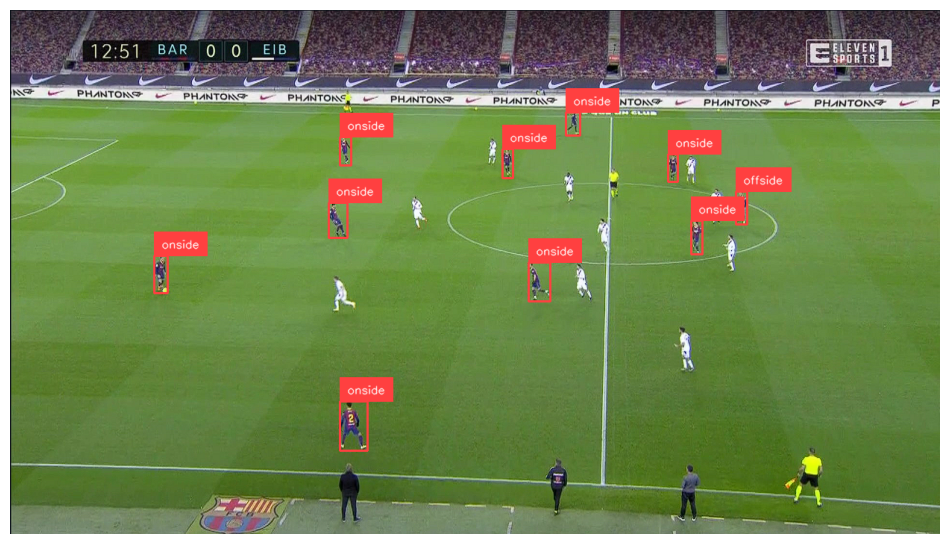

In [84]:
sv.plot_image(annotated_image_5)